In [1]:
import torch
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
USE_GPU = True
num_class = 100
dtype = torch.float32 # we will be using float throughout this tutorial
device = torch.device("cpu")
try:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device('cpu')
except:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: mps


In [3]:
BASE = "lung_colon_image_set/"

In [4]:
class LungColonDS(torchvision.datasets.DatasetFolder):
    def find_classes(self, directory: str):
        classes = ["colon_image_sets/colon_aca","colon_image_sets/colon_n","lung_image_sets/lung_aca","lung_image_sets/lung_n","lung_image_sets/lung_scc"]
        return classes, {val:ind for ind, val in enumerate(classes)}

In [5]:
lung_colon_dataset = LungColonDS(BASE,torchvision.io.read_image, extensions = [".jpeg"])

In [6]:
lung_colon_dataset.classes

['colon_image_sets/colon_aca',
 'colon_image_sets/colon_n',
 'lung_image_sets/lung_aca',
 'lung_image_sets/lung_n',
 'lung_image_sets/lung_scc']

In [7]:
train_count = int(0.7*len(lung_colon_dataset))
valid_count = len(lung_colon_dataset) - train_count
train_dataset, valid_dataset = torch.utils.data.random_split(lung_colon_dataset, [train_count, valid_count])

In [8]:
train_subset = np.array([lung_colon_dataset[i] for i in train_dataset.indices if i<100])

/var/folders/0x/m1s6swtx3c5dl010fbkgb5280000gn/T/ipykernel_9491/14402734.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  train_subset = np.array([lung_colon_dataset[i] for i in train_dataset.indices if i<100])
/var/folders/0x/m1s6swtx3c5dl010fbkgb5280000gn/T/ipykernel_9491/14402734.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_subset = np.array([lung

# Plotting a Image from the Data Set

/var/folders/0x/m1s6swtx3c5dl010fbkgb5280000gn/T/ipykernel_9491/3583082000.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682147326800/work/aten/src/ATen/native/TensorShape.cpp:3582.)
  plt.imshow(train_subset[0][0].T)


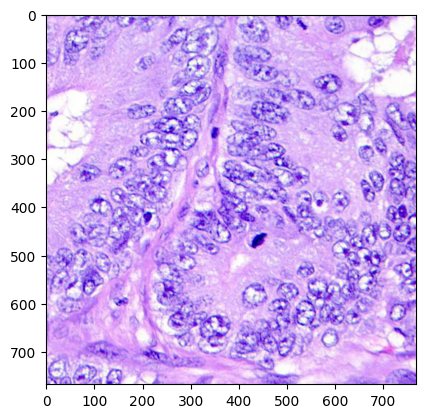

In [9]:
plt.imshow(train_subset[0][0].T)

# Confirming We Have Representative Datasets
Confirming we have multiple examples of each class in DataSets

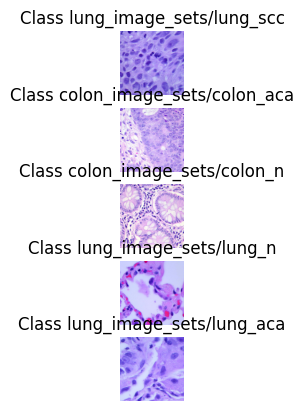

In [10]:
found = dict()
fig = plt.figure()
axes = []
for i in train_dataset:
    if i[1] not in found:
        found[i[1]] = i[0]
        axes.append(fig.add_subplot(5, 1, len(axes)+1))
        axes[-1].imshow(i[0].T)
        axes[-1].set_title(f"Class {lung_colon_dataset.classes[i[1]]}")
        axes[-1].set_axis_off()
    if len(found) == 5:
        break
assert len(found) == 5
plt.show()

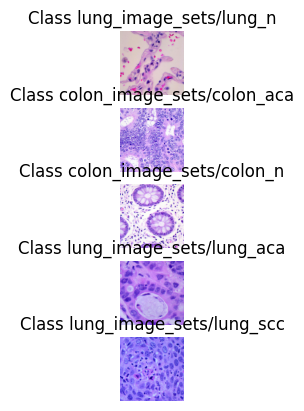

In [11]:
found = dict()
fig = plt.figure()
axes = []
for i in valid_dataset:
    if i[1] not in found:
        found[i[1]] = i[0]
        axes.append(fig.add_subplot(5, 1, len(axes)+1))
        axes[-1].imshow(i[0].T)
        axes[-1].set_title(f"Class {lung_colon_dataset.classes[i[1]]}")
        axes[-1].set_axis_off()
    if len(found) == 5:
        break
assert len(found) == 5
plt.show()

# Making Dataloader
Dataloaders is how we will present the data to the trainer, so we need to create this object. In the future, these can be adjusted to handle any kind of new distribution we want to make

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [13]:
train_features, train_labels = next(iter(train_dataloader))

In [14]:
train_features.shape

torch.Size([64, 3, 768, 768])

In [15]:
import resnet
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [16]:
learning_rate = 2.5e-4
model = nn.Sequential(torchvision.transforms.Resize((32,32)),resnet.ResNet(batchNorm=True))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
def check_accuracy_part34(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: The accuracy of the model
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_dataloader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if (t + 1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t + 1, loss.item()))
                check_accuracy_part34(test_dataloader, model)
                print()
    return check_accuracy_part34(test_dataloader, model)

In [18]:
print_every = 100
train_part34(model, optimizer, epochs=10)
print_every = 100

/Users/aman/opt/anaconda3/envs/ece285/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 0, Iteration 100, loss = 0.2636


KeyboardInterrupt: 